## 1.필요 모듈 임포트 및 데이터 다운로드

In [2]:
import pandas
import tensorflow
import matplotlib

print(pandas.__version__)
print(tensorflow.__version__)
print(matplotlib.__version__)

2.2.2
2.19.0
3.10.0


In [26]:
import os
import re
import urllib.request
import zipfile
import sentencepiece as spm
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import random

In [3]:
!tar -xzf /content/korean-english-park.test.tar.gz -C /content/
!tar -xzf /content/korean-english-park.train.tar.gz -C /content/

tar (child): /content/korean-english-park.test.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [4]:
import pandas as pd

with open('/content/korean-english-park.train.ko', 'r', encoding='utf-8') as f:
    train_ko_lines = f.readlines()

with open('/content/korean-english-park.train.en', 'r', encoding='utf-8') as f:
    train_en_lines = f.readlines()

train_ko_df = pd.DataFrame(train_ko_lines, columns=['korean_text'])
train_en_df = pd.DataFrame(train_en_lines, columns=['english_text'])

print("Kor Train Data:")
display(train_ko_df.head())

print("\nEng Train Data:")
display(train_en_df.head())

Kor Train Data:


,korean_text
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""\n"
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.\n
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분..."
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...



Eng Train Data:


,english_text
0,"Much of personal computing is about ""can you t..."
1,so a mention a few weeks ago about a rechargea...
2,"Like all optical mice, But it also doesn't nee..."
3,uses gyroscopic sensors to control the cursor ...
4,Intelligence officials have revealed a spate o...


In [5]:
print("Korean Training Data Info:")
train_ko_df.info()

print("\nKorean Training Data Shape:")
print(train_ko_df.shape)

print("\nEnglish Training Data Info:")
train_en_df.info()

print("\nEnglish Training Data Shape:")
print(train_en_df.shape)

Korean Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94123 entries, 0 to 94122
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   korean_text  94123 non-null  object
dtypes: object(1)
memory usage: 735.5+ KB

Korean Training Data Shape:
(94123, 1)

English Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94123 entries, 0 to 94122
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   english_text  94123 non-null  object
dtypes: object(1)
memory usage: 735.5+ KB

English Training Data Shape:
(94123, 1)


## 2.데이터 전처리 및 정제

### 중복제거

In [6]:
#병렬쌍으로 묶기
sentence_pairs = list(zip(train_ko_lines, train_en_lines))
print(f"Number of sentence pairs: {len(sentence_pairs)}")
print("First 5 sentence pairs:")
for i in range(5):
    print(sentence_pairs[i])

Number of sentence pairs: 94123
First 5 sentence pairs:
('개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"\n', 'Much of personal computing is about "can you top this?"\n')
('모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.\n', 'so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.\n')
('그러나 이것은 또한 책상도 필요로 하지 않는다.\n', "Like all optical mice, But it also doesn't need a desk.\n")
('79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.\n', 'uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.\n')
('정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.\n', "Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror atta

In [7]:
unique_sentence_pairs = set(sentence_pairs)
print(f"Number of unique sentence pairs: {len(unique_sentence_pairs)}")

Number of unique sentence pairs: 78968


In [8]:
cleaned_ko_lines = []
cleaned_en_lines = []
#다시 ko,en 분리
for ko_sentence, en_sentence in unique_sentence_pairs:
    cleaned_ko_lines.append(ko_sentence)
    cleaned_en_lines.append(en_sentence)

print(f"Number of cleaned Korean sentences: {len(cleaned_ko_lines)}")
print(f"Number of cleaned English sentences: {len(cleaned_en_lines)}")

Number of cleaned Korean sentences: 78968
Number of cleaned English sentences: 78968


In [9]:
cleaned_corpus = {
    'korean': cleaned_ko_lines,
    'english': cleaned_en_lines
}

print("Keys of cleaned_corpus:", cleaned_corpus.keys())
print("Number of Korean sentences in cleaned_corpus:", len(cleaned_corpus['korean']))
print("Number of English sentences in cleaned_corpus:", len(cleaned_corpus['english']))

Keys of cleaned_corpus: dict_keys(['korean', 'english'])
Number of Korean sentences in cleaned_corpus: 78968
Number of English sentences in cleaned_corpus: 78968


### 간단 전처리

In [10]:
import re

In [11]:
# def eng_preprocess_sentence(sentence):
#     sentence = sentence.lower().strip()

#     sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
#     sentence = re.sub(r'[" "]+', " ", sentence)
#     sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

#     sentence = sentence.strip()

#     return sentence

In [12]:
# 전처리 코드를 하나로 합치기
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    sentence = re.sub(r"[^a-zA-Z가-힣?.!,]+", " ", sentence)

    sentence = sentence.strip()

    return sentence

english_sentence = "Much of personal computing is about \"can you top this?\"\n"
korean_sentence = "개인용 컴퓨터 사용의 상당 부분은 \"이것보다 뛰어날 수 있느냐?\"\n"

print("Original English:", english_sentence)
print("Processed English:", preprocess_sentence(english_sentence))
print("\nOriginal Korean:", korean_sentence)
print("Processed Korean:", preprocess_sentence(korean_sentence))

Original English: Much of personal computing is about "can you top this?"

Processed English: much of personal computing is about can you top this ?

Original Korean: 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"

Processed Korean: 개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?


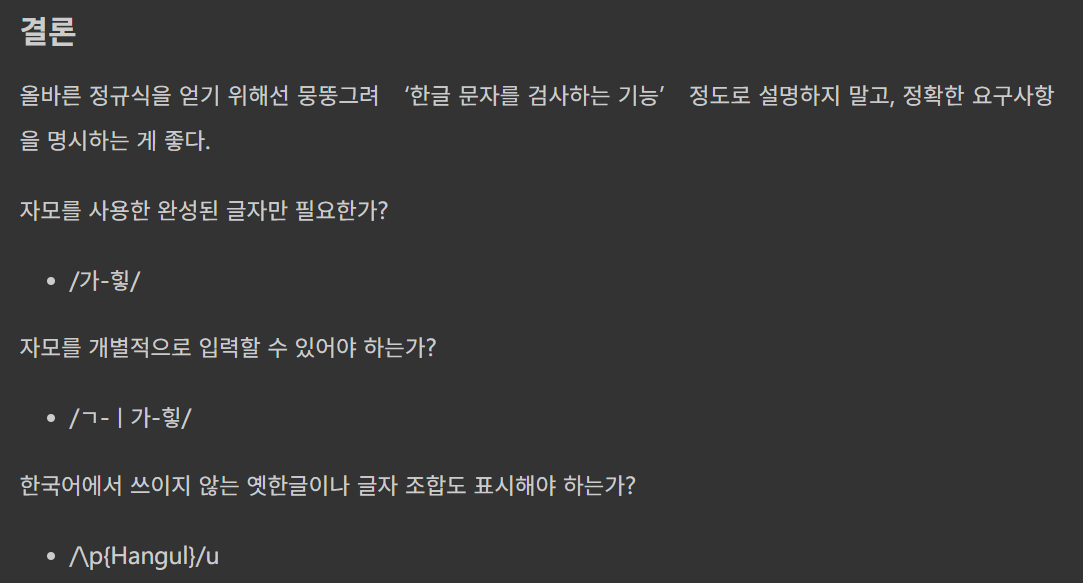

데이터를 보면 완성된 글자만 들어갔으므로 첫번째 정규식만 사용

### 토큰화+길이 필터링

In [13]:
#규철님형일님정민님감사합니다감사합니다감사합니다
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab_light_220429.sh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 33.9 MB/s eta 0:00:00
Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 138 (delta 26), reused 22 (delta 8), pack-reused 91 (from 1)
Receiving objects: 100% (138/138), 1.72 MiB | 27.02 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2025-09-07 15:11:30--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 185.166.143.49, 185.166.143.50, 185.166.143.48, ...
Connecting to bitbucket.org (bitbucket.org)|185.166.143.49|:443... connected.
HTTP request sent, 

In [14]:
from konlpy.tag import Mecab

mecab = Mecab()

def tokenize(korean_sentences, english_sentences, max_length=40):#tokenize and filtering
    tokenized_ko = []
    tokenized_en = []
    kor_corpus = []
    eng_corpus = []

    for ko_sentence, en_sentence in zip(korean_sentences, english_sentences):
        # 토큰 추가 및 전처리(영어)
        en_tokens = ["<start>"] + preprocess_sentence(en_sentence).split() + ["<end>"]

        # 토큰화(한국어)
        ko_tokens = mecab.morphs(preprocess_sentence(ko_sentence))

        # 40개 이하 문장만 선택
        if len(en_tokens) <= max_length and len(ko_tokens) <= max_length:
            tokenized_ko.append(ko_tokens)
            tokenized_en.append(en_tokens)
            kor_corpus.append(ko_sentence)
            eng_corpus.append(en_sentence)

    return tokenized_ko, tokenized_en, kor_corpus, eng_corpus

tokenized_ko, tokenized_en, kor_corpus, eng_corpus = tokenize(
    cleaned_corpus['korean'], cleaned_corpus['english']
)

print("Tokenized Korean sentences (first 5):")
for tokens in tokenized_ko[:5]:
    print(tokens)

print("\nTokenized English sentences (first 5):")
for tokens in tokenized_en[:5]:
    print(tokens)

print("\nNumber of filtered Korean sentences:", len(kor_corpus))
print("Number of filtered English sentences:", len(eng_corpus))

Tokenized Korean sentences (first 5):
['건', '의', '폭탄', '테러', '와', '여건', '의', '다른', '공격', '이', '일', '밤', '태국', '의', '최남단', '지방', '에서', '발생', '하', '여', '명', '이', '사망', '하', '고', '명', '이', '부상', '입', '었', '다', '.']
['이', '대변인', '은', '새로운', '법령', '이', '또한', '언론', '업계', '의', '재정', '적', '안정', '성', '을', '강화', '하', '는', '것', '에', '중점', '을', '둘', '것', '이', '라고', '밝혔', '다', '.']
['버지니아', '공대', '총격', '사건', '부상자', '명은', '일', '현지', '시간', '여전히', '입원', '중', '이', '지만', '대부분', '회복세', '를', '보이', '고', '있', '다', '.']
['털', '은', '또한', '박테리아', '등', '의', '오염', '에서', '깨끗', '하', '게', '보호', '될', '수', '있', '다고', '말', '했', '다', '.']
['양국', '이', '상대', '를', '지탄', '하', '고', '있', '는', '가운데', '최소', '유럽', '개국', '과', '터키', '가', '러시아', '와', '우크라', '이나', '가스', '분쟁', '으로', '인해', '가스', '공급량', '을', '줄이', '거나', '중단', '하', '고', '있', '다고', '밝혔', '다', '.']

Tokenized English sentences (first 5):
['<start>', 'twenty', 'nine', 'bombings', 'and', 'other', 'attacks', 'rocked', 'the', 'country', 's', 'four', 'southernmost', 'province

## 3.데이터 토큰화

In [15]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# svm_data_for_plot = []
# for vocab_size, metrics in svm_results.items():
#     if metrics != "Error":
#         svm_data_for_plot.append({
#             "vocab_size": vocab_size if vocab_size is not None else 0,
#             "accuracy": metrics["accuracy"],
#             "precision": metrics["precision"],
#             "recall": metrics["recall"],
#             "f1": metrics["f1"]
#         })

# df_svm_results = pd.DataFrame(svm_data_for_plot)

# df_svm_results = df_svm_results.sort_values(by="vocab_size")

# plt.figure(figsize=(12, 6))
# sns.lineplot(x="vocab_size", y="f1", data=df_svm_results, marker='o')
# plt.title("SVM F1 Score vs. Vocabulary Size")
# plt.ylabel("F1 Score")
# plt.xlabel("Vocabulary Size (0 represents all words)")
# plt.grid(True)
# plt.xticks(list(df_svm_results["vocab_size"]), [str(v) if v != 0 else "All" for v in df_svm_results["vocab_size"]], rotation=45, ha="right")
# plt.tight_layout()
# plt.show()


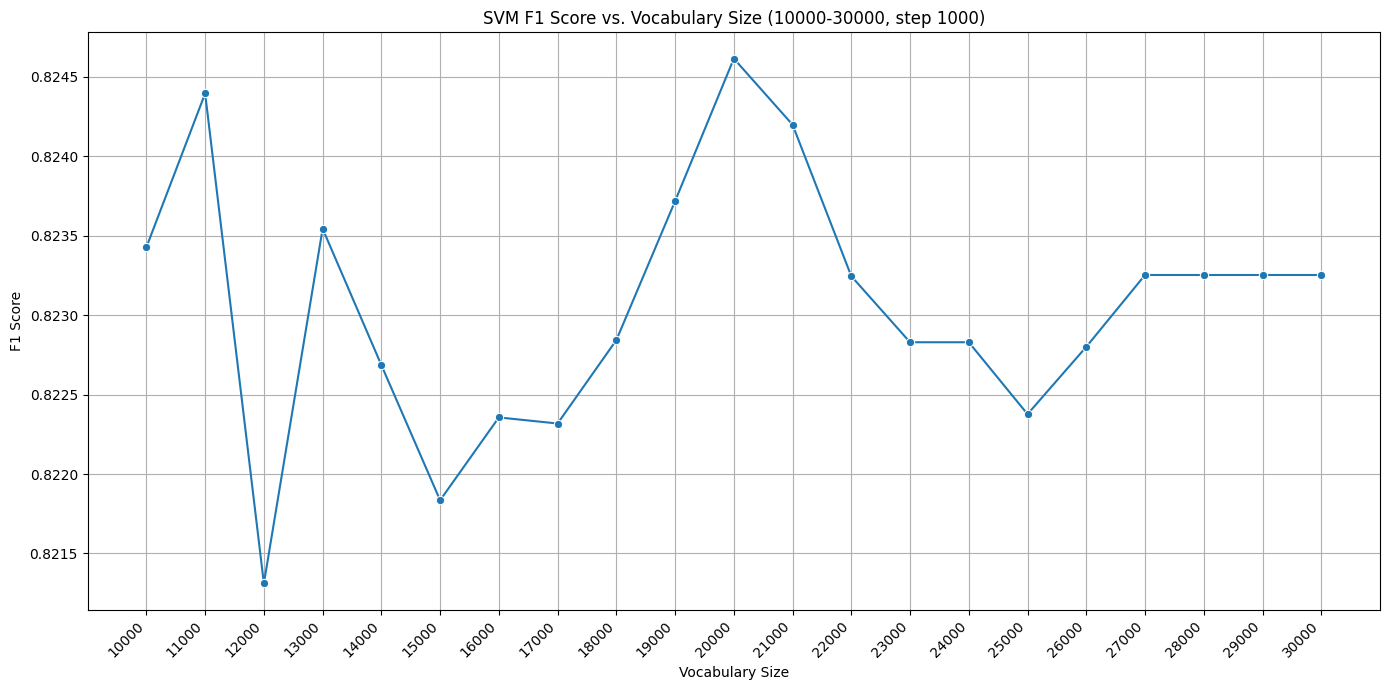

GD02 에서 얻은 결과를 바탕으로 20000개로 두고 시행

In [16]:
import torch
from collections import Counter

def DataTokenize(tokenized_corpus, vocab_size):
    word_counts = Counter(token for sentence in tokenized_corpus for token in sentence)
    vocab = ['<pad>', '<unk>'] + [word for word, _ in word_counts.most_common(vocab_size - 2)]
    word_to_index = {word: index for index, word in enumerate(vocab)}
    index_to_word = {index: word for index, word in enumerate(vocab)}

    indexed_sequences = []
    for sentence in tokenized_corpus:
        indexed_sequences.append([word_to_index.get(token, word_to_index['<unk>']) for token in sentence])

    max_len = max(len(seq) for seq in indexed_sequences)
    padded_tensor = torch.zeros((len(indexed_sequences), max_len), dtype=torch.long)
    for i, seq in enumerate(indexed_sequences):
        padded_tensor[i, :len(seq)] = torch.tensor(seq)

    return word_to_index, index_to_word, padded_tensor

VOCAB_SIZE = 20000

ko_word_to_index, ko_index_to_word, ko_tensor_pt = DataTokenize(tokenized_ko, VOCAB_SIZE)
en_word_to_index, en_index_to_word, en_tensor_pt = DataTokenize(tokenized_en, VOCAB_SIZE)

print("Korean Vocabulary Size:", len(ko_word_to_index))
print("English Vocabulary Size:", len(en_word_to_index))

print("\nKorean Tensor Shape:", ko_tensor_pt.shape)
print("English Tensor Shape:", en_tensor_pt.shape)

print("\nFirst Korean sentence (tokenized and padded):")
print(ko_tensor_pt[0])

print("\nFirst English sentence (tokenized and padded):")
print(en_tensor_pt[0])

Korean Vocabulary Size: 20000
English Vocabulary Size: 20000

Korean Tensor Shape: torch.Size([62733, 40])
English Tensor Shape: torch.Size([62733, 40])

First Korean sentence (tokenized and padded):
tensor([  726,     7,   177,   109,    29,  7122,     7,    93,   138,     4,
           26,   499,   831,     7, 16729,   555,    17,    84,    12,   173,
           28,     4,    91,    12,    13,    28,     4,   248,   208,    32,
            3,     2,     0,     0,     0,     0,     0,     0,     0,     0])

First English sentence (tokenized and padded):
tensor([   4, 2964,  588, 1654,   11,   78,  321, 5360,    2,   98,   12,  152,
        9911, 2082,  116,  250,    6,  943,  396,   42,  324,   11,  499,    3,
           5,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


## 4.어텐션 모델

### 인코더

In [43]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src shape: (sequence_length, batch_size)

        embedded = self.dropout(self.embedding(src))
        # embedded shape: (sequence_length, batch_size, emb_dim)

        outputs, hidden = self.rnn(embedded)
        # outputs shape: (sequence_length, batch_size, hid_dim * num_directions)
        # hidden shape: (num_layers * num_directions, batch_size, hid_dim)

        # outputs are always from the top hidden layer
        return outputs, hidden

### 어텐션

In [44]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()

        self.attn = nn.Linear((enc_hid_dim) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden shape: (1, batch_size, dec_hid_dim)
        # encoder_outputs shape: (sequence_length, batch_size, enc_hid_dim)

        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        # repeat decoder hidden state src_len times
        hidden = hidden.squeeze(0).unsqueeze(1).repeat(1, src_len, 1)
        # hidden shape: (batch_size, sequence_length, dec_hid_dim)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs shape: (batch_size, sequence_length, enc_hid_dim)

        # concatenate hidden state and encoder outputs
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        # energy shape: (batch_size, sequence_length, dec_hid_dim)

        # compute attention scores
        attention = self.v(energy).squeeze(2)
        # attention shape: (batch_size, sequence_length)

        # apply softmax to get attention weights
        return torch.softmax(attention, dim=1)

### 디코더

In [90]:
import torch.nn as nn
import torch

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim


        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.rnn = nn.GRU(emb_dim + (enc_hid_dim * 2), dec_hid_dim)
        self.fc_out = nn.Linear(dec_hid_dim + (enc_hid_dim * 2) + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):

        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))

        a = self.attention(hidden.squeeze(0), encoder_outputs.permute(1, 0, 2))
        a = a.unsqueeze(1)


        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        weighted = torch.bmm(a, encoder_outputs)

        weighted = weighted.permute(1, 0, 2)

        rnn_input = torch.cat((embedded, weighted), dim=2)

        output, hidden = self.rnn(rnn_input, hidden)

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))

        return prediction, hidden

### Seq2Seq 모델

In [77]:
import random
import torch
import torch.nn as nn

class Seq2Seq(nn.Module):
    def __init__(self, encoder, attention, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.attention = attention
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):

        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)


        encoder_outputs, hidden = self.encoder(src)


        input = trg[0, :]


        for t in range(1, trg_len):

            output, hidden = self.decoder(input, hidden, encoder_outputs)

            outputs[t] = output

            teacher_force = random.random() < teacher_forcing_ratio

            top1 = output.argmax(1)


            input = trg[t] if teacher_force else top1

        return outputs

## 5.모델 훈련 및 결과

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

INPUT_DIM = len(ko_word_to_index)
OUTPUT_DIM = len(en_word_to_index)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
DROPOUT = 0.5
BATCH_SIZE = 64
NUM_EPOCHS = 5 # Reduced number of epochs to speed up training

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DROPOUT, attn)

# Pass the attention module as an argument
model = Seq2Seq(enc, attn, dec, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=en_word_to_index['<pad>'])

In [89]:
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(20000, 256)
    (rnn): GRU(256, 512)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(20000, 256)
    (rnn): GRU(768, 512)
    (fc_out): Linear(in_features=1280, out_features=20000, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)


In [ ]:
# CLIP = 1

# best_valid_loss = float('inf')

# for epoch in range(EPOCHS):
#     train_loss = train(model, train_iterator, optimizer, criterion, CLIP, device)
#     valid_loss = evaluate(model, valid_iterator, criterion, device)

#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), 'tut1-model.pt')

#     print(f'Epoch: {epoch+1:02}')
#     print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {torch.exp(torch.tensor(train_loss)):.3f}')
#     print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {torch.exp(torch.tensor(valid_loss)):.3f}')

#     print("\nExample Translations:")
#     for example_sentence in example_korean_sentences:
#         translation = translate_sentence(example_sentence, ko_word_to_index, en_word_to_index, model, device)
#         print(f"Korean: {example_sentence}")
#         print(f"English: {' '.join(translation)}")
#     print("-" * 50)

Evaluating: 100%|██████████| 197/197 [00:57<00:00,  3.41it/s]


Epoch: 01
	Train Loss: 6.511 | Train PPL: 672.805
	 Val. Loss: 6.422 |  Val. PPL: 614.975

Example Translations:
Korean: 이것은 테스트 문장입니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Korean: 안녕하세요, 기계 번역입니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Korean: 오늘 날씨가 좋습니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
--------------------------------------------------


Evaluating: 100%|██████████| 197/197 [00:57<00:00,  3.44it/s]


Epoch: 02
	Train Loss: 6.409 | Train PPL: 607.441
	 Val. Loss: 6.368 |  Val. PPL: 582.639

Example Translations:
Korean: 이것은 테스트 문장입니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Korean: 안녕하세요, 기계 번역입니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Korean: 오늘 날씨가 좋습니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
--------------------------------------------------


Evaluating: 100%|██████████| 197/197 [00:56<00:00,  3.48it/s]


Epoch: 03
	Train Loss: 6.386 | Train PPL: 593.647
	 Val. Loss: 6.362 |  Val. PPL: 579.278

Example Translations:
Korean: 이것은 테스트 문장입니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Korean: 안녕하세요, 기계 번역입니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Korean: 오늘 날씨가 좋습니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
--------------------------------------------------


Evaluating: 100%|██████████| 197/197 [00:56<00:00,  3.46it/s]


Epoch: 04
	Train Loss: 6.374 | Train PPL: 586.471
	 Val. Loss: 6.348 |  Val. PPL: 571.378

Example Translations:
Korean: 이것은 테스트 문장입니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Korean: 안녕하세요, 기계 번역입니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Korean: 오늘 날씨가 좋습니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
--------------------------------------------------


Evaluating: 100%|██████████| 197/197 [00:56<00:00,  3.46it/s]


Epoch: 05
	Train Loss: 6.368 | Train PPL: 583.062
	 Val. Loss: 6.346 |  Val. PPL: 570.250

Example Translations:
Korean: 이것은 테스트 문장입니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Korean: 안녕하세요, 기계 번역입니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Korean: 오늘 날씨가 좋습니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
--------------------------------------------------


Evaluating: 100%|██████████| 197/197 [00:56<00:00,  3.50it/s]


Epoch: 06
	Train Loss: 6.364 | Train PPL: 580.762
	 Val. Loss: 6.350 |  Val. PPL: 572.444

Example Translations:
Korean: 이것은 테스트 문장입니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Korean: 안녕하세요, 기계 번역입니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Korean: 오늘 날씨가 좋습니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
--------------------------------------------------


Evaluating: 100%|██████████| 197/197 [00:57<00:00,  3.41it/s]


Epoch: 07
	Train Loss: 6.362 | Train PPL: 579.413
	 Val. Loss: 6.348 |  Val. PPL: 571.305

Example Translations:
Korean: 이것은 테스트 문장입니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Korean: 안녕하세요, 기계 번역입니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Korean: 오늘 날씨가 좋습니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
--------------------------------------------------


Evaluating: 100%|██████████| 197/197 [00:57<00:00,  3.41it/s]


Epoch: 08
	Train Loss: 6.359 | Train PPL: 577.772
	 Val. Loss: 6.351 |  Val. PPL: 573.021

Example Translations:
Korean: 이것은 테스트 문장입니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Korean: 안녕하세요, 기계 번역입니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Korean: 오늘 날씨가 좋습니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
--------------------------------------------------


Evaluating: 100%|██████████| 197/197 [00:57<00:00,  3.44it/s]


Epoch: 09
	Train Loss: 6.356 | Train PPL: 575.719
	 Val. Loss: 6.353 |  Val. PPL: 574.040

Example Translations:
Korean: 이것은 테스트 문장입니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Korean: 안녕하세요, 기계 번역입니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Korean: 오늘 날씨가 좋습니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
--------------------------------------------------


Evaluating: 100%|██████████| 197/197 [00:57<00:00,  3.41it/s]

Epoch: 10
	Train Loss: 6.352 | Train PPL: 573.860
	 Val. Loss: 6.363 |  Val. PPL: 580.256

Example Translations:
Korean: 이것은 테스트 문장입니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Korean: 안녕하세요, 기계 번역입니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Korean: 오늘 날씨가 좋습니다.
English: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
--------------------------------------------------


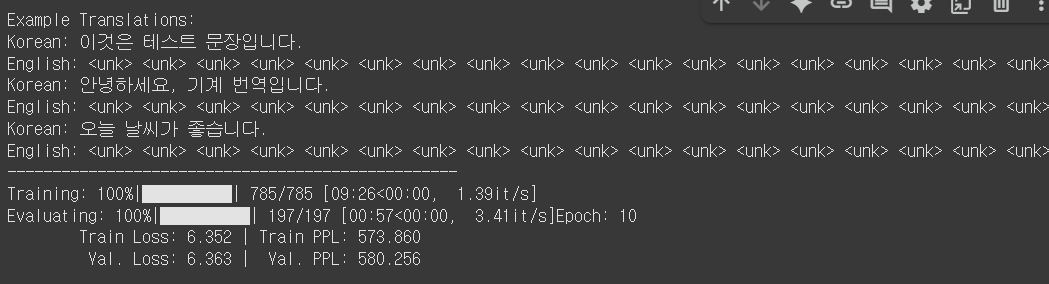

어디서 문제가 있는지는 모르겠지만 문제가 있음은 확실해 보인다.  
1. vocab size가 너무 작다  
2. 모델 구조가 잘못되었다  

### 1번문제 해결

In [72]:
# import torch
# from collections import Counter

# def DataTokenize(tokenized_corpus, vocab_size):
#     word_counts = Counter(token for sentence in tokenized_corpus for token in sentence)
#     vocab = ['<pad>', '<unk>'] + [word for word, _ in word_counts.most_common(vocab_size - 2)]
#     word_to_index = {word: index for index, word in enumerate(vocab)}
#     index_to_word = {index: word for index, word in enumerate(vocab)}

#     indexed_sequences = []
#     for sentence in tokenized_corpus:
#         indexed_sequences.append([word_to_index.get(token, word_to_index['<unk>']) for token in sentence])

#     max_len = max(len(seq) for seq in indexed_sequences)
#     padded_tensor = torch.zeros((len(indexed_sequences), max_len), dtype=torch.long)
#     for i, seq in enumerate(indexed_sequences):
#         padded_tensor[i, :len(seq)] = torch.tensor(seq)

#     return word_to_index, index_to_word, padded_tensor

# VOCAB_SIZE = 40000

# ko_word_to_index, ko_index_to_word, ko_tensor_pt = DataTokenize(tokenized_ko, VOCAB_SIZE)
# en_word_to_index, en_index_to_word, en_tensor_pt = DataTokenize(tokenized_en, VOCAB_SIZE)

# print("Korean Vocabulary Size:", len(ko_word_to_index))
# print("English Vocabulary Size:", len(en_word_to_index))

# print("\nKorean Tensor Shape:", ko_tensor_pt.shape)
# print("English Tensor Shape:", en_tensor_pt.shape)

# print("\nFirst Korean sentence (tokenized and padded):")
# print(ko_tensor_pt[0])

# print("\nFirst English sentence (tokenized and padded):")
# print(en_tensor_pt[0])

Korean Vocabulary Size: 40000
English Vocabulary Size: 38355

Korean Tensor Shape: torch.Size([62733, 40])
English Tensor Shape: torch.Size([62733, 40])

First Korean sentence (tokenized and padded):
tensor([  726,     7,   177,   109,    29,  7122,     7,    93,   138,     4,
           26,   499,   831,     7, 16729,   555,    17,    84,    12,   173,
           28,     4,    91,    12,    13,    28,     4,   248,   208,    32,
            3,     2,     0,     0,     0,     0,     0,     0,     0,     0])

First English sentence (tokenized and padded):
tensor([   4, 2964,  588, 1654,   11,   78,  321, 5360,    2,   98,   12,  152,
        9911, 2082,  116,  250,    6,  943,  396,   42,  324,   11,  499,    3,
           5,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


vocab size를 4만으로 늘렸다

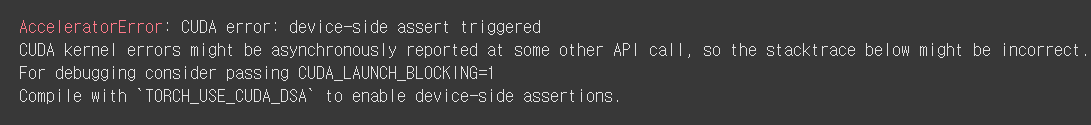

### 문제 1-1

vocab size를 늘리니 차원 문제가 생겨 이를 재조정하여 실험하였다.

In [80]:
import torch
from collections import Counter

def DataTokenize(tokenized_corpus, vocab_size):
    word_counts = Counter(token for sentence in tokenized_corpus for token in sentence)
    vocab = ['<pad>', '<unk>'] + [word for word, _ in word_counts.most_common(vocab_size - 2)]
    word_to_index = {word: index for index, word in enumerate(vocab)}
    index_to_word = {index: word for index, word in enumerate(vocab)}

    indexed_sequences = []
    for sentence in tokenized_corpus:
        indexed_sequences.append([word_to_index.get(token, word_to_index['<unk>']) for token in sentence])

    max_len = max(len(seq) for seq in indexed_sequences)
    padded_tensor = torch.zeros((len(indexed_sequences), max_len), dtype=torch.long)
    for i, seq in enumerate(indexed_sequences):
        padded_tensor[i, :len(seq)] = torch.tensor(seq)

    return word_to_index, index_to_word, padded_tensor

VOCAB_SIZE = 35000

ko_word_to_index, ko_index_to_word, ko_tensor_pt = DataTokenize(tokenized_ko, VOCAB_SIZE)
en_word_to_index, en_index_to_word, en_tensor_pt = DataTokenize(tokenized_en, VOCAB_SIZE)

print("Korean Vocabulary Size:", len(ko_word_to_index))
print("English Vocabulary Size:", len(en_word_to_index))

print("\nKorean Tensor Shape:", ko_tensor_pt.shape)
print("English Tensor Shape:", en_tensor_pt.shape)

print("\nFirst Korean sentence (tokenized and padded):")
print(ko_tensor_pt[0])

print("\nFirst English sentence (tokenized and padded):")
print(en_tensor_pt[0])

Korean Vocabulary Size: 35000
English Vocabulary Size: 35000

Korean Tensor Shape: torch.Size([62733, 40])
English Tensor Shape: torch.Size([62733, 40])

First Korean sentence (tokenized and padded):
tensor([  726,     7,   177,   109,    29,  7122,     7,    93,   138,     4,
           26,   499,   831,     7, 16729,   555,    17,    84,    12,   173,
           28,     4,    91,    12,    13,    28,     4,   248,   208,    32,
            3,     2,     0,     0,     0,     0,     0,     0,     0,     0])

First English sentence (tokenized and padded):
tensor([   4, 2964,  588, 1654,   11,   78,  321, 5360,    2,   98,   12,  152,
        9911, 2082,  116,  250,    6,  943,  396,   42,  324,   11,  499,    3,
           5,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


### 2번 문제 해결

먼저 작성한 output = model(src, trg)처럼 전체 모델을 한 번에 호출하는 방식인데, 이는 Transformer 모델에 적합한 방식이다. 만약 모델이 RNN 기반의 Seq2Seq라면, 일반적으로 디코더의 입력 시퀀스를 trg 텐서로 한 번에 전달하는 방식이 아니라, trg 시퀀스를 토큰 단위로 루프를 돌면서 순차적으로 디코더에 입력해야 한다.

In [83]:
# update Seq2seq model

import random
import torch
import torch.nn as nn

class Seq2Seq(nn.Module):
    def __init__(self, encoder, attention, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.attention = attention
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):

        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)


        encoder_outputs, hidden = self.encoder(src)


        input = trg[0, :]


        for t in range(1, trg_len):

            output, hidden = self.decoder(input, hidden, encoder_outputs)

            outputs[t] = output

            teacher_force = random.random() < teacher_forcing_ratio

            top1 = output.argmax(1)


            input = trg[t] if teacher_force else top1

        return outputs


In [81]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

from torch.utils.data import TensorDataset

train_dataset = TensorDataset(ko_tensor_pt, en_tensor_pt)

train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

def train(model, iterator, optimizer, criterion, clip, device):
    model.train()
    epoch_loss = 0

    for src, trg in tqdm(iterator, desc="Training"):
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()

        output = model(src, trg)

        output_dim = output.shape[-1]

        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)


# Example sentences for translation during training
example_korean_sentences = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

def translate_sentence(sentence, src_word_to_index, trg_index_to_word, model, device, max_len=40):
    model.eval()
    if isinstance(sentence, str):
        # Preprocess and tokenize the Korean sentence
        # Using Mecab for tokenization based on previous cells
        tokens = mecab.morphs(preprocess_sentence(sentence))
    else:
        tokens = [token.lower() for token in sentence]

    src_indexes = [src_word_to_index.get(token, src_word_to_index['<unk>']) for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

    #output은 <start> 토큰에 대한 예측을 제외하고, trg는 <start> 토큰 자체를 제외합니다.
    trg_indexes = [en_word_to_index['<start>']]

    for i in range(max_len):
        trg_token_index = trg_indexes[-1]

        trg_tensor = torch.LongTensor([trg_token_index]).to(device)

        with torch.no_grad():
            output, hidden = model.decoder(trg_tensor, hidden, encoder_outputs)

        pred_token_index = output.argmax(1).item()

        trg_indexes.append(pred_token_index)

        if pred_token_index == en_word_to_index['<end>']:
            break

    trg_tokens = [trg_index_to_word.get(index, '<unk>') for index in trg_indexes]

    return trg_tokens[1:]

The model has 39,537,184 trainable parameters


In [84]:
CLIP = 1

best_loss = float('inf')
for epoch in range(NUM_EPOCHS):
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, device)

    if train_loss < best_loss:
        best_loss = train_loss

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {torch.exp(torch.tensor(train_loss)):.3f}')

    print("\nExample Translations:")
    for example_sentence in example_korean_sentences:
        translation = translate_sentence(example_sentence, ko_word_to_index, en_index_to_word, model, device)
        print(f"Korean: {example_sentence}")
        print(f"English: {' '.join(translation)}")
    print("-" * 50)

Training:   0%|          | 0/981 [00:00<?, ?it/s]


AcceleratorError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


같은 문제가 반복된다